# Transmissivity analysis from Polar Data Catalogue datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.basemap import Basemap, cm
import matplotlib
import netCDF4 as nc
import cmocean
import glob
import pandas as pd 
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
from oceans import sw_extras as swe
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')
import pickle

import scipy.io
import seaborn as sns

%matplotlib notebook

In [3]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [4]:
bathy_masked = np.ma.masked_where((mesh_bathy > 0.1), mesh_bathy)

# ArcticNet transmissivity data from Polar Data Catalogue

In [5]:
folder_ArcticNet = '/ocean/brogalla/GEOTRACES/data/ArcticNet/'
sub1  = 'ArcticNet1003b_CTD_NorthWestPassage-v20140523/'
sub2  = 'ArcticNet0904a_CTD_CanadianArcticBaffinBay_v20140923/'
sub3  = 'ArcticNet1101_CTD_BaffinBay_NorthwestPassage_v20140922/'
sub4  = 'ArcticNet1001b_CTD_NorthWestPassage_v20140523/'
sub5  = 'ArcticNet1103b_ CTD_BaffinBay_NorthwestPassage_v20140922/'
sub6  = '2014_Amundsen_CTD_v1/'
sub7  = '2015_Amundsen_CTD_v1/'
sub8  = '2016_Amundsen_CTD_v1/'
sub9  = '2017_Amundsen_CTD_v1/'
sub10 = '2018_Amundsen_CTD_v1/'
sub11 = 'ArcticNet_1304_CTD_BaffinBay_NorthWestPassage_v20141117/'
sub12 = 'ArcticNet_1305_CTD_NorthwestPassage_v20140708/'
sub13 = 'CCIN509_ArcticNet_0603c_FoxeBassinHudsonBay_int/'
sub14 = 'CCIN510_ArcticNet_0603d_LabradorSeaAndFjords_int/'
sub15 = 'CCIN515_CASES_0303_Baffin_Bay_19_05_2011/'

List of filenames for each of these datasets

In [6]:
files1 = glob.glob(folder_ArcticNet+sub1+'*.int')
files2 = glob.glob(folder_ArcticNet+sub2+'*.int')
files3 = glob.glob(folder_ArcticNet+sub3+'*.int')
files4 = glob.glob(folder_ArcticNet+sub4+'*.int')
files5 = glob.glob(folder_ArcticNet+sub5+'*.int')
files6 = glob.glob(folder_ArcticNet+sub6+'*.int')
files7 = glob.glob(folder_ArcticNet+sub7+'*.int')
files8 = glob.glob(folder_ArcticNet+sub8+'*.int')
files9 = glob.glob(folder_ArcticNet+sub9+'*.int')
files10 = glob.glob(folder_ArcticNet+sub10+'*.int')
files11 = glob.glob(folder_ArcticNet+sub11+'*.int')
files12 = glob.glob(folder_ArcticNet+sub12+'*.int')
files13 = glob.glob(folder_ArcticNet+sub13+'*.int')
files14 = glob.glob(folder_ArcticNet+sub14+'*.int')
files15 = glob.glob(folder_ArcticNet+sub15+'*.int')

Function to read in data

In [7]:
c = ['#dbf397', '#9bb976', '#adccef', '#3381d8', '#19406c']

In [8]:
def read_CTD(files):
    
    stn_lats=[]
    stn_lons=[]
    data_array=np.empty((len(files),5500,2)) # shape: (file, random length, [pressure, transmissivity])
    data_array[:] = np.nan
    i=0
    
    for file in files:       
        stn = pd.read_fwf(file)
        stn_data = stn.iloc[:,1]
        
        try:
            stn_lat  = float(stn_data[stn_data.str.contains('Latitude', na=False)].str.extract('(\d+\.*\d*)', expand=False))
            stn_lon  = float(stn_data[stn_data.str.contains('Longitude', na=False)].str.extract('(\d+\.*\d*)', expand=False))
            
            # Don't use stations that are way out of the domain:
            if (stn_lat < 63) or (-1*stn_lon < -140 ): 
                stn_lats = np.append(stn_lats, np.nan)
                stn_lons = np.append(stn_lons, np.nan)
            else:
                stn_lats = np.append(stn_lats, stn_lat)
                stn_lons = np.append(stn_lons, -1*stn_lon)

                # First data row to read:
                first_row = stn_data[stn_data.str.contains('----', na=False)].index[0] + 1 

                data  = pd.read_table(file, header=first_row-1, sep='\s+')
                data  = data.drop(0) # drop empty row
                data  = data.dropna().astype(float)
                number_rows1 = len(data['Pres'])
                number_rows2 = len(data['Trans'])
                data_array[i,0:number_rows1,0] = np.array(data['Pres'])  # Pressure
                data_array[i,0:number_rows2,1] = np.array(data['Trans']) # Transmissivity
        except:
                stn_lats = np.append(stn_lats, np.nan)
                stn_lons = np.append(stn_lons, np.nan)
        
        i+=1
    
    return stn_lats, stn_lons, data_array

In [9]:
stn_lats1, stn_lons1, data_array1 = read_CTD(files1)
stn_lats2, stn_lons2, data_array2 = read_CTD(files2)
stn_lats3, stn_lons3, data_array3 = read_CTD(files3)
stn_lats4, stn_lons4, data_array4 = read_CTD(files4)
stn_lats5, stn_lons5, data_array5 = read_CTD(files5)
stn_lats6, stn_lons6, data_array6 = read_CTD(files6)
stn_lats7, stn_lons7, data_array7 = read_CTD(files7)
stn_lats8, stn_lons8, data_array8 = read_CTD(files8)
stn_lats9, stn_lons9, data_array9 = read_CTD(files9)
stn_lats10, stn_lons10, data_array10 = read_CTD(files10)
stn_lats11, stn_lons11, data_array11 = read_CTD(files11)
stn_lats12, stn_lons12, data_array12 = read_CTD(files12)
stn_lats13, stn_lons13, data_array13 = read_CTD(files13)
stn_lats14, stn_lons14, data_array14 = read_CTD(files14)
stn_lats15, stn_lons15, data_array15 = read_CTD(files15)

In [16]:
fig, axs = plt.subplots(3,4, figsize=(11,14))

titles = ['ArcticNet 1003b', 'ArcticNet 0904a', 'ArcticNet 1101', 'ArcticNet 1001b', 'ArcticNet 1103b', \
          'Amundsen 2014', 'Amundsen 2015', 'Amundsen 2016', 'Amundsen 2017', 'Amundsen 2018', \
          'ArcticNet 1304', 'ArcticNet 1305 / 0603c']
   
axs[0,0].set_xlabel('Transmissivity [%]')
axs[0,1].set_xlabel('Transmissivity [%]')
axs[0,2].set_xlabel('Transmissivity [%]')
axs[0,3].set_xlabel('Transmissivity [%]')
axs[0,0].set_ylabel('Depth [m]')
axs[1,0].set_ylabel('Depth [m]')
axs[2,0].set_ylabel('Depth [m]')

d1 = data_array1[depth_diff1 < 30]; d2 = data_array2[depth_diff2 < 30];
d3 = data_array3[depth_diff3 < 30]; d4 = data_array4[depth_diff4 < 30];
d5 = data_array5[depth_diff5 < 30]; d6 = data_array6[depth_diff6 < 30];
d7 = data_array7[depth_diff7 < 30]; d8 = data_array8[depth_diff8 < 30];
d9 = data_array9[depth_diff9 < 30]; d10 = data_array10[depth_diff10 < 30];
d11 = data_array11[depth_diff11 < 30]; d12 = data_array12[depth_diff12 < 30];
d13 = data_array13[depth_diff13 < 30]; d14 = data_array14[depth_diff14 < 30];
d15 = data_array15[depth_diff15 < 30]; 


[axs[0,0].plot(d1[stns,:,1], d1[stns,:,0], c=c[0]) for stns in range(0,d1.shape[0])]
[axs[0,1].plot(d2[stns,:,1], d2[stns,:,0], c=c[3]) for stns in range(0,d2.shape[0])]
[axs[0,2].plot(d3[stns,:,1], d3[stns,:,0], c=c[1]) for stns in range(0,d3.shape[0])]
[axs[0,3].plot(d4[stns,:,1], d4[stns,:,0], c=c[4]) for stns in range(0,d4.shape[0])]
[axs[1,0].plot(d5[stns,:,1], d5[stns,:,0], c=c[2]) for stns in range(0,d5.shape[0])]
[axs[1,1].plot(d6[stns,:,1], d6[stns,:,0], c=c[5]) for stns in range(0,d6.shape[0])]
[axs[1,2].plot(d7[stns,:,1], d7[stns,:,0], c=c[6]) for stns in range(0,d7.shape[0])]
[axs[1,3].plot(d8[stns,:,1], d8[stns,:,0], c=c[7]) for stns in range(0,d8.shape[0])]
[axs[2,0].plot(d9[stns,:,1], d9[stns,:,0], c=c[8]) for stns in range(0,d9.shape[0])]
[axs[2,1].plot(d10[stns,:,1], d10[stns,:,0], c=c[9]) for stns in range(0,d10.shape[0])]
[axs[2,2].plot(d11[stns,:,1], d11[stns,:,0], c=c[10]) for stns in range(0,d11.shape[0])]
[axs[2,3].plot(d12[stns,:,1], d12[stns,:,0], c=c[11]) for stns in range(0,d12.shape[0])]
[axs[2,3].plot(d13[stns,:,1], d13[stns,:,0], c=c[12]) for stns in range(0,d13.shape[0])]

i=0
for ax in axs.flatten():
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlim(86,104)
    ax.set_ylim(820,-20)
    ax.plot([100, 100], [-20,820],'--k',linewidth=2.0)
    ax.set_title(titles[i])
    i+=1
    
axs[0,1].set_xlim(75,90)    
axs[0,2].set_ylim(500,-20)
axs[2,1].set_ylim(500,-20)
axs[2,3].set_ylim(500,-20)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---transmissivity-profiles', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>

IndexError: list index out of range

## Metric for when transmissivity profiles indicate that resuspension is important

1. Compare cast depth with bottom depth at the same lat & lon
2. Smooth data
3. Calculate derivative of running average
4. Take the sum of the derivative values for the lowest 50 m and compare with average transmissivity derivative above that.

In [17]:
def find_closest_model_point(
    lon, lat, model_lons, model_lats, grid='NEMO', land_mask=None,
    tols={
        'NEMO': {'tol_lon': 0.104, 'tol_lat': 0.0388},
        'GEM2.5': {'tol_lon': 0.016, 'tol_lat': 0.012},
        }
):

    if grid not in tols:
        raise KeyError(
            'The provided grid type is not in tols. '
            'Use another grid type or add your grid type to tols.')

    # Search for a grid point with longitude and latitude within
    # tolerance of measured location
    j_list, i_list = np.where(
        np.logical_and(
            (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
                            model_lons < lon + tols[grid]['tol_lon'])),
            (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
                            model_lats < lat + tols[grid]['tol_lat']))
        )
    )

    if len(j_list) == 0:
        # Added by BMM March 2017
        # If including points outside of domain:
        return np.nan, np.nan
        # raise ValueError(
        #    'No model point found. tol_lon/tol_lat too small or '
        #    'lon/lat outside of domain.')
    try:
        j, i = map(np.asscalar, (j_list, i_list))
    except ValueError:
        # Several points within tolerance
        # Calculate distances for all and choose the closest

        # Avoiding array indexing because some functions
        # pass in model_lons and model_lats as netcdf4 objects
        # (which treat 'model_lons[j_list, i_list]' differently)
        lons = [model_lons[j_list[n], i_list[n]] for n in range(len(j_list))]
        lats = [model_lats[j_list[n], i_list[n]] for n in range(len(j_list))]
        dists = haversine(
            np.array([lon] * i_list.size), np.array([lat] * j_list.size),
            lons, lats)
        n = dists.argmin()
        j, i = map(np.asscalar, (j_list[n], i_list[n]))

    # If point is on land and land mask is provided
    # try to find closest water point
    if land_mask is None or not land_mask[j, i]:
        return j, i
    try:
        return _spiral_search_for_closest_water_point(
            j, i, land_mask, lon, lat, model_lons, model_lats)
    except ValueError:
        raise ValueError(
            'lat/lon on land and no nearby water point found')


In [18]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [19]:
def find_bathy(cast_depth, lon, lat, mesh_lon=mesh_lon, mesh_lat=mesh_lat):

    # Find bathymetry
    i, j        = find_closest_model_point(lon, lat, mesh_lon, mesh_lat)
    bathy_depth = mesh_bathy[i,j]
    
    return bathy_depth, cast_depth

In [20]:
def compare_depth(data_array, stn_lons, stn_lats):
    # Depth above bottom for the end of each cast:
    cruise_bathy =[]
    cruise_cast  =[]
    cruise_diff  =[]
    
    bottom = (~np.isnan(data_array[:,:,0])).sum(axis = 1) - 1
    bottom[bottom < 0] = 0
    
    for i in range(0,len(bottom)):
        try:
            bathy, cast   = find_bathy(bottom[i], stn_lons[i], stn_lats[i])
            cruise_bathy  = np.append(cruise_bathy, bathy)
            cruise_cast   = np.append(cruise_cast, cast)

            cruise_diff   = np.append(cruise_diff, np.abs(bathy - cast))
        except:
            cruise_bathy  = np.append(cruise_bathy, np.nan)
            cruise_cast   = np.append(cruise_cast, np.nan)
            cruise_diff   = np.append(cruise_diff, np.nan)
    
    return cruise_diff

In [21]:
depth_diff1 = compare_depth(data_array1, stn_lons1, stn_lats1)
depth_diff2 = compare_depth(data_array2, stn_lons2, stn_lats2)
depth_diff3 = compare_depth(data_array3, stn_lons3, stn_lats3)
depth_diff4 = compare_depth(data_array4, stn_lons4, stn_lats4)
depth_diff5 = compare_depth(data_array5, stn_lons5, stn_lats5)
depth_diff6 = compare_depth(data_array6, stn_lons6, stn_lats6)
depth_diff7 = compare_depth(data_array7, stn_lons7, stn_lats7)
depth_diff8 = compare_depth(data_array8, stn_lons8, stn_lats8)
depth_diff9 = compare_depth(data_array9, stn_lons9, stn_lats9)
depth_diff10 = compare_depth(data_array10, stn_lons10, stn_lats10)
depth_diff11 = compare_depth(data_array11, stn_lons11, stn_lats11)
depth_diff12 = compare_depth(data_array12, stn_lons12, stn_lats12)
depth_diff13 = compare_depth(data_array13, stn_lons13, stn_lats13)
depth_diff14 = compare_depth(data_array14, stn_lons14, stn_lats14)
depth_diff15 = compare_depth(data_array15, stn_lons15, stn_lats15)

1. Stations with casts within about 30 m of the ocean floor:

In [22]:
c = ['#96cc60', '#ca1b74', '#f4d171', '#71a9cc', '#b81233', \
    '#9999ff', '#ffccff', '#05464f',  '#a9b7ae', '#625ad9', \
    '#ff9d4c', '#be9b7b', '#cc9709', '#f7f4e8', '#4a0b69']

<IPython.core.display.Javascript object>


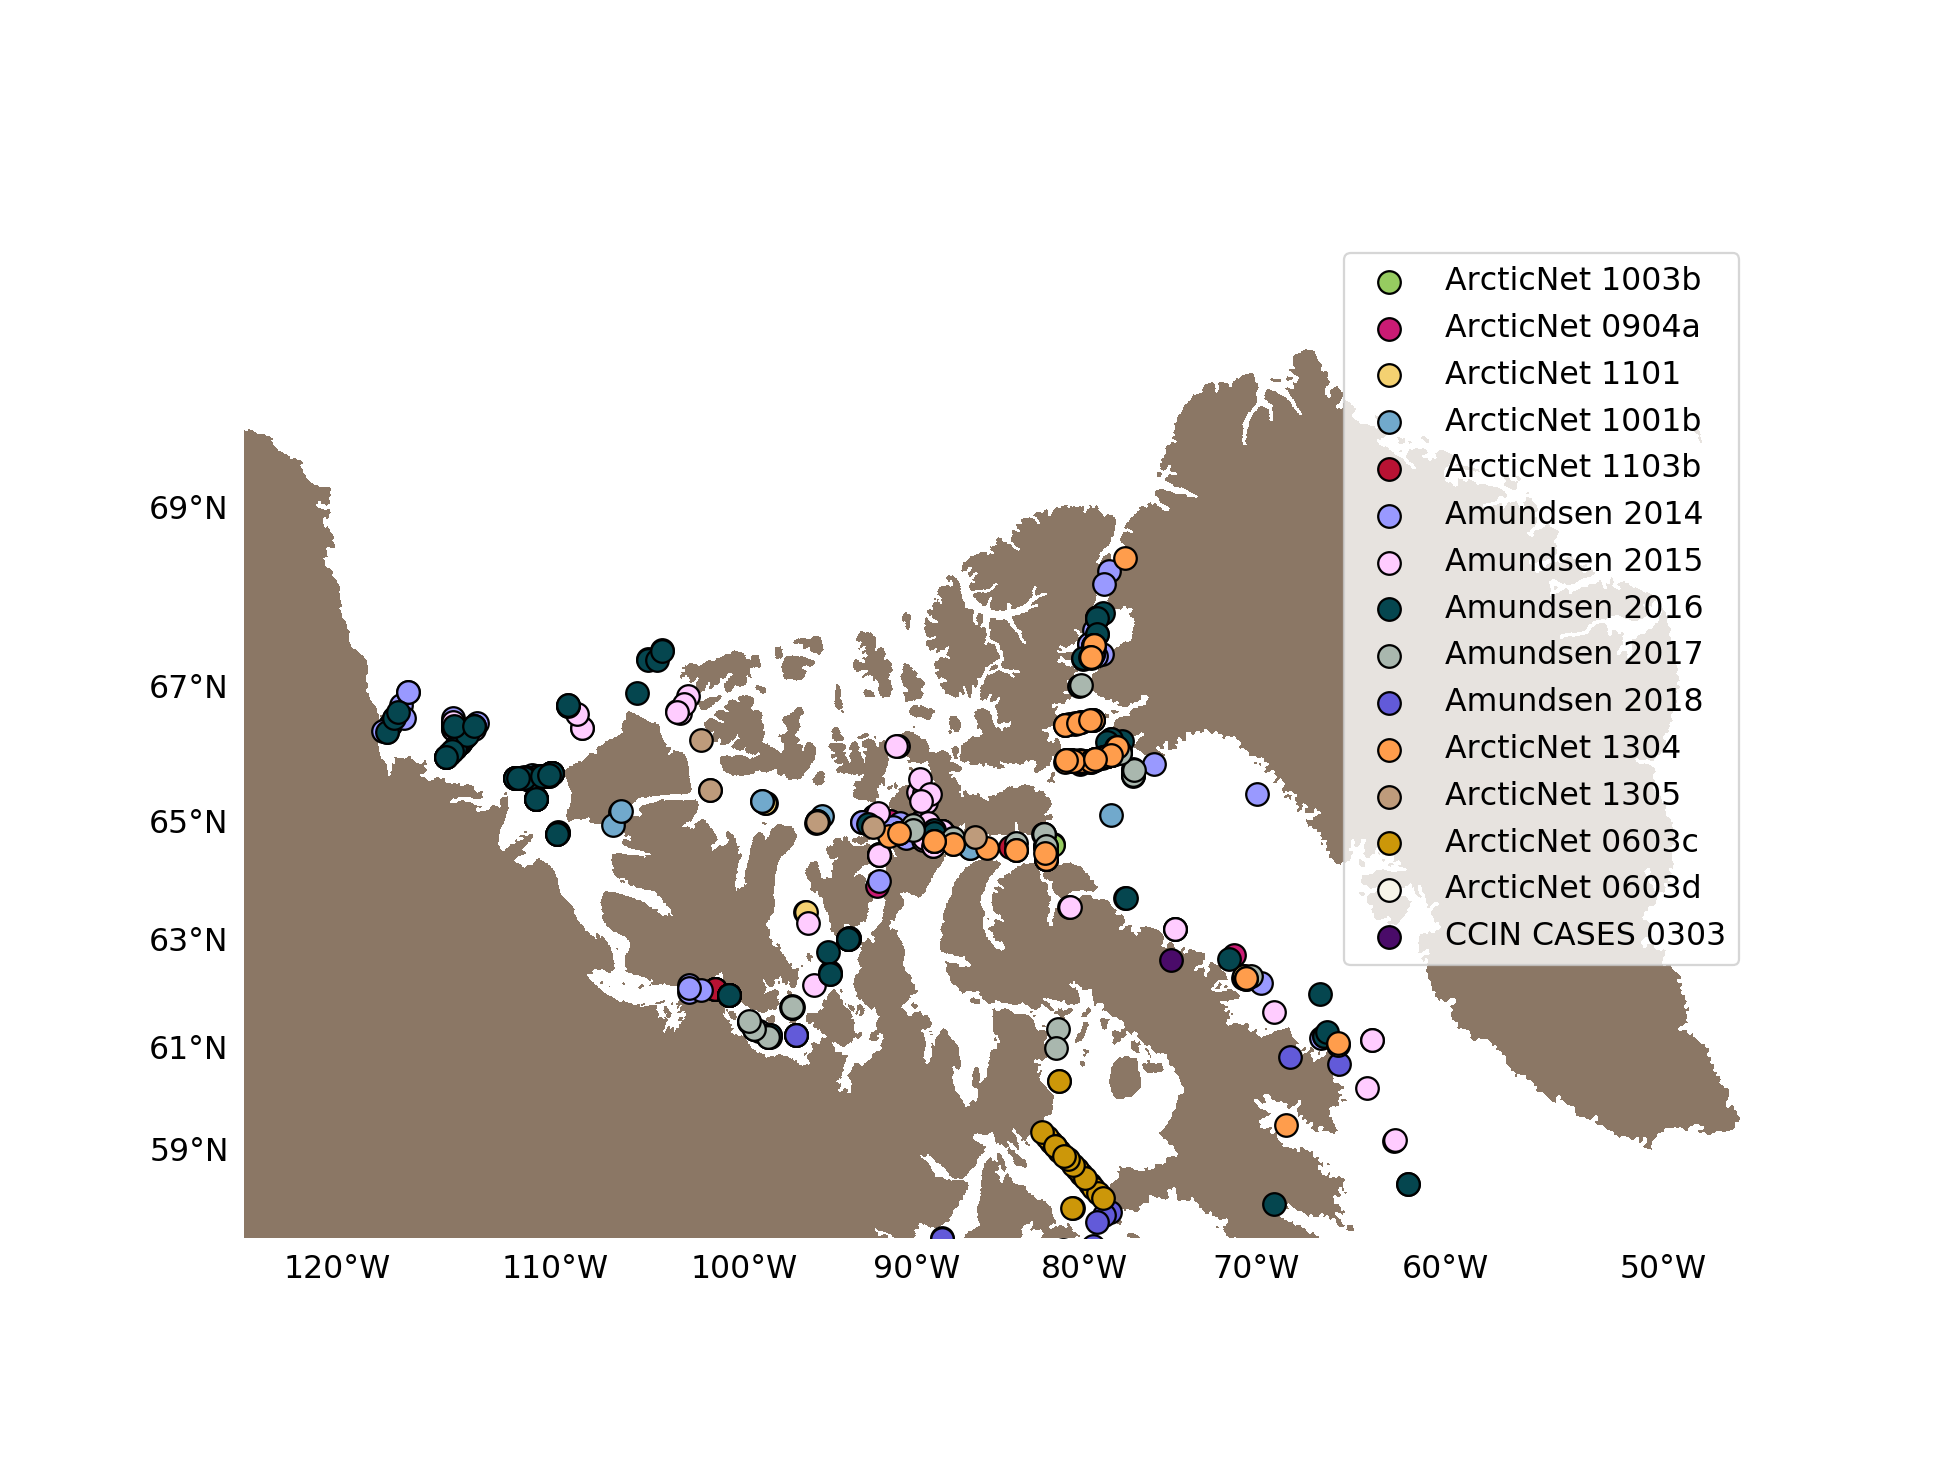

In [42]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

x1, y1   = proj1(stn_lons1[depth_diff1 < 30], stn_lats1[depth_diff1 < 30])
x2, y2   = proj1(stn_lons2[depth_diff2 < 30], stn_lats2[depth_diff2 < 30])
x3, y3   = proj1(stn_lons3[depth_diff3 < 30], stn_lats3[depth_diff3 < 30])
x4, y4   = proj1(stn_lons4[depth_diff4 < 30], stn_lats4[depth_diff4 < 30])
x5, y5   = proj1(stn_lons5[depth_diff5 < 30], stn_lats5[depth_diff5 < 30])
x6, y6   = proj1(stn_lons6[depth_diff6 < 30], stn_lats6[depth_diff6 < 30])
x7, y7   = proj1(stn_lons7[depth_diff7 < 30], stn_lats7[depth_diff7 < 30])
x8, y8   = proj1(stn_lons8[depth_diff8 < 30], stn_lats8[depth_diff8 < 30])
x9, y9   = proj1(stn_lons9[depth_diff9 < 30], stn_lats9[depth_diff9 < 30])
x10, y10 = proj1(stn_lons10[depth_diff10 < 30], stn_lats10[depth_diff10 < 30])
x11, y11 = proj1(stn_lons11[depth_diff11 < 30], stn_lats11[depth_diff11 < 30])
x12, y12 = proj1(stn_lons12[depth_diff12 < 30], stn_lats12[depth_diff12 < 30]);
x13, y13 = proj1(stn_lons13[depth_diff13 < 30], stn_lats13[depth_diff13 < 30])
x14, y14 = proj1(stn_lons14[depth_diff14 < 30], stn_lats14[depth_diff14 < 30]);
x15, y15 = proj1(stn_lons15[depth_diff15 < 30], stn_lats15[depth_diff15 < 30])

proj1.scatter(x1, y1, marker='.', s=400, edgecolor='k', color=c[0], zorder=3, label='ArcticNet 1003b')
proj1.scatter(x3, y3, marker='.', s=400, edgecolor='k', color=c[1], zorder=3, label='ArcticNet 0904a')
proj1.scatter(x5, y5, marker='.', s=400, edgecolor='k', color=c[2], zorder=3, label='ArcticNet 1101')
proj1.scatter(x2, y2, marker='.', s=400, edgecolor='k', color=c[3], zorder=3, label='ArcticNet 1001b')
proj1.scatter(x4, y4, marker='.', s=400, edgecolor='k', color=c[4], zorder=3, label='ArcticNet 1103b')
proj1.scatter(x6, y6, marker='.', s=400, edgecolor='k', color=c[5], zorder=3, label='Amundsen 2014')
proj1.scatter(x7, y7, marker='.', s=400, edgecolor='k', color=c[6], zorder=3, label='Amundsen 2015')
proj1.scatter(x8, y8, marker='.', s=400, edgecolor='k', color=c[7], zorder=3, label='Amundsen 2016')
proj1.scatter(x9, y9, marker='.', s=400, edgecolor='k', color=c[8], zorder=3, label='Amundsen 2017')
proj1.scatter(x10, y10, marker='.', s=400, edgecolor='k', color=c[9], zorder=3, label='Amundsen 2018')
proj1.scatter(x11, y11, marker='.', s=400, edgecolor='k', color=c[10], zorder=3, label='ArcticNet 1304')
proj1.scatter(x12, y12, marker='.', s=400, edgecolor='k', color=c[11], zorder=3, label='ArcticNet 1305')
proj1.scatter(x13, y13, marker='.', s=400, edgecolor='k', color=c[12], zorder=3, label='ArcticNet 0603c')
proj1.scatter(x14, y14, marker='.', s=400, edgecolor='k', color=c[13], zorder=3, label='ArcticNet 0603d')
proj1.scatter(x15, y15, marker='.', s=400, edgecolor='k', color=c[14], zorder=3, label='CCIN CASES 0303')

ax1.legend(fontsize=14, frameon=True, loc=1)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---cast-locations.png', bbox_inches='tight', dpi=300)

2. Bottom depth vs. Transmissivity:

In [23]:
def compare_depth2(data_array, stn_lons, stn_lats):
    # Depth above bottom for the end of each cast:
    cruise_bathy =[]
    cruise_cast  =[]
    cruise_diff  =[]
    
    bottom = (~np.isnan(data_array[:,:,0])).sum(axis = 1) - 1
    bottom[bottom < 0] = 0
    
    for i in range(0,len(bottom)):
        try:
            bathy, cast   = find_bathy(bottom[i], stn_lons[i], stn_lats[i])
            cruise_bathy  = np.append(cruise_bathy, bathy)
            cruise_cast   = np.append(cruise_cast, cast)

            cruise_diff   = np.append(cruise_diff, np.abs(bathy - cast))
        except:
            cruise_bathy  = np.append(cruise_bathy, np.nan)
            cruise_cast   = np.append(cruise_cast, np.nan)
            cruise_diff   = np.append(cruise_diff, np.nan)
    
    return cruise_bathy, cruise_cast, cruise_diff

In [24]:
def bottom_trans(data_array, stn_lons, stn_lats):
    
    cruise_bathy, cruise_cast, depth_diff = compare_depth2(data_array, stn_lons, stn_lats)
    
    bottom = (~np.isnan(data_array[:,:,0])).sum(axis = 1) - 1
    bottom[bottom < 0] = 0
    
    # CTD data:
    data_x1 = data_array[depth_diff < 30, :, 1]#[~np.isnan(data_array[depth_diff < 30, :, 1])] # transmissivity
    data_y1 = data_array[depth_diff < 30, :, 0]#[~np.isnan(data_array[depth_diff < 30, :, 0])] # depth of measurement (pressure) (cast, depths)
    bottom_cast = bottom[depth_diff < 30]#[~np.isnan(bottom[depth_diff < 30])]
    
    # depth of bathymetry
    data_y2 = cruise_bathy[depth_diff < 30]#[~np.isnan(cruise_bathy[depth_diff < 30])]
    
    # loop through each cast
    trans_array = []
    depth_array = []
    for i in range(0, len(bottom_cast)):
        ind1 = np.argmin(np.abs(data_y1[i,:]-bottom_cast[i])) # find closest point to bottom bathymetry
        ind2 = ind1-5
        ind3 = ind2-80
        
        # calculate transmissivity drop by taking average of bottom 5m - average of upper 80m
        if ind3 < 0:
            transmissivity = np.nanmean(data_x1[i, ind2:ind1]) - np.nanmean(data_x1[i, :])
        else:
            transmissivity = np.nanmean(data_x1[i, ind2:ind1]) - np.nanmean(data_x1[i, ind3:ind2])
#             transmissivity = np.nanmean(data_x1[i, ind2:ind1]) - np.nanmean(data_x1[i, :])
        depth          = data_y2[i] 
        
        trans_array = np.append(trans_array, transmissivity)
        depth_array = np.append(depth_array, depth)
        
    return list(trans_array), list(depth_array)

In [25]:
trans1, depth1 = bottom_trans(data_array1, stn_lons1, stn_lats1)
trans2, depth2 = bottom_trans(data_array2, stn_lons2, stn_lats2)
trans3, depth3 = bottom_trans(data_array3, stn_lons3, stn_lats3)
trans4, depth4 = bottom_trans(data_array4, stn_lons4, stn_lats4)
trans5, depth5 = bottom_trans(data_array5, stn_lons5, stn_lats5)
trans6, depth6 = bottom_trans(data_array6, stn_lons6, stn_lats6)
trans7, depth7 = bottom_trans(data_array7, stn_lons7, stn_lats7)
trans8, depth8 = bottom_trans(data_array8, stn_lons8, stn_lats8)
trans9, depth9 = bottom_trans(data_array9, stn_lons9, stn_lats9)
trans10, depth10 = bottom_trans(data_array10, stn_lons10, stn_lats10)
trans11, depth11 = bottom_trans(data_array11, stn_lons11, stn_lats11)
trans12, depth12 = bottom_trans(data_array12, stn_lons12, stn_lats12)
trans13, depth13 = bottom_trans(data_array13, stn_lons13, stn_lats13)
trans14, depth14 = bottom_trans(data_array14, stn_lons14, stn_lats14)
trans15, depth15 = bottom_trans(data_array15, stn_lons15, stn_lats15)

In [26]:
transmissivity   = np.array(trans1+trans2+trans3+trans4+trans5+\
                   trans6+trans7+trans8+trans9+trans10+\
                   trans11+trans12+trans13+trans15)
bathymetry_depth = np.array(depth1+depth2+depth3+depth4+depth5+\
                   depth6+depth7+depth8+depth9+depth10+\
                   depth11+depth12+depth13+depth15)

In [27]:
trans1  = np.array(trans1); trans2  = np.array(trans2); trans3  = np.array(trans3);
trans4  = np.array(trans4); trans5  = np.array(trans5); trans6  = np.array(trans6);
trans7  = np.array(trans7); trans8  = np.array(trans8); trans9  = np.array(trans9);
trans10 = np.array(trans10); trans11 = np.array(trans11); trans12 = np.array(trans12);
trans13 = np.array(trans13); trans14 = np.array(trans14); trans15 = np.array(trans15);

In [28]:
print('Number of casts on which the transmissivity drop estimate is based: ', \
      len(transmissivity[~np.isnan(transmissivity)]))
print('------------------------------------------------------------------------')
print('Cruise ID       Casts --- Casts used')
print('------------------------------------------------------------------------')
print('ArcticNet 0603c: ', data_array13.shape[0], ' ---', len(trans13[~np.isnan(trans13)]))
print('ArcticNet 0603d: ', data_array14.shape[0], ' ---', len(trans14[~np.isnan(trans14)]))
print('ArcticNet 0904a: ', data_array2.shape[0], ' ---', len(trans2[~np.isnan(trans2)]))
print('ArcticNet 1001b: ', data_array4.shape[0], ' ---', len(trans4[~np.isnan(trans4)]))
print('ArcticNet 1003b: ', data_array1.shape[0], ' ---', len(trans1[~np.isnan(trans1)]))
print('ArcticNet 1101:  ', data_array3.shape[0], ' ---', len(trans3[~np.isnan(trans3)]))
print('ArcticNet 1103b: ', data_array5.shape[0], ' ---', len(trans5[~np.isnan(trans5)]))
print('ArcticNet 1304:  ', data_array11.shape[0], '---', len(trans11[~np.isnan(trans11)]))
print('ArcticNet 1305:  ', data_array12.shape[0], ' ---', len(trans12[~np.isnan(trans12)]))
print('Amundsen 2014:   ', data_array6.shape[0], '---', len(trans6[~np.isnan(trans6)]))
print('Amundsen 2015:   ', data_array7.shape[0], '---', len(trans7[~np.isnan(trans7)]))
print('Amundsen 2016:   ', data_array8.shape[0], '---', len(trans8[~np.isnan(trans8)]))
print('Amundsen 2017:   ', data_array9.shape[0], '---', len(trans9[~np.isnan(trans9)]))
print('Amundsen 2018:   ', data_array10.shape[0], '---', len(trans10[~np.isnan(trans10)]))

Number of casts on which the transmissivity drop estimate is based:  550
------------------------------------------------------------------------
Cruise ID       Casts --- Casts used
------------------------------------------------------------------------
ArcticNet 0603c:  21  --- 20
ArcticNet 0603d:  22  --- 0
ArcticNet 0904a:  63  --- 43
ArcticNet 1001b:  12  --- 7
ArcticNet 1003b:  27  --- 14
ArcticNet 1101:   33  --- 15
ArcticNet 1103b:  45  --- 29
ArcticNet 1304:   115 --- 52
ArcticNet 1305:   11  --- 7
Amundsen 2014:    191 --- 91
Amundsen 2015:    275 --- 123
Amundsen 2016:    420 --- 99
Amundsen 2017:    101 --- 39
Amundsen 2018:    139 --- 11


<IPython.core.display.Javascript object>


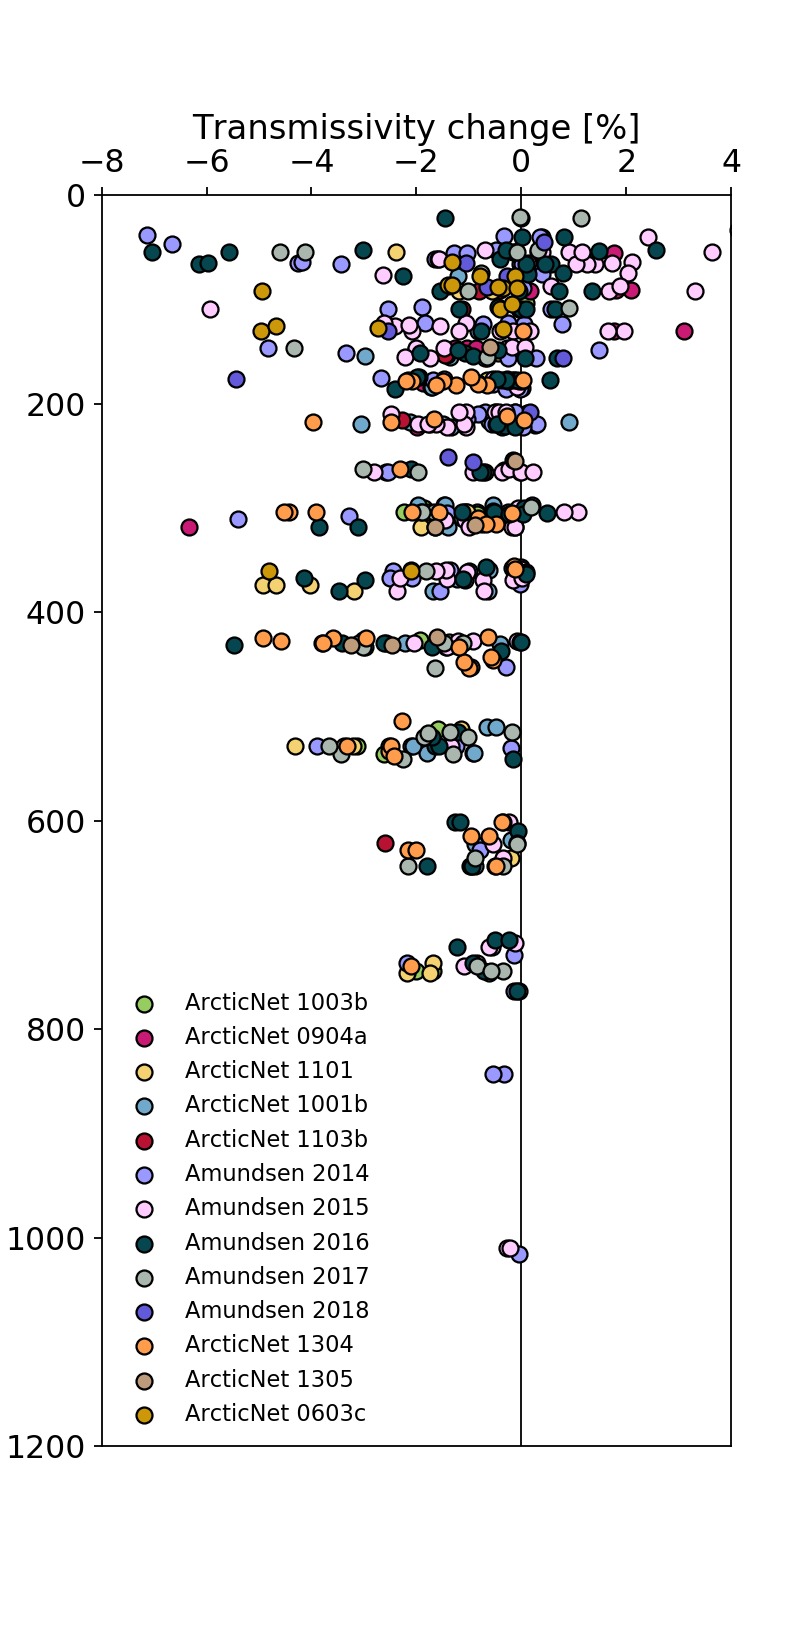

In [280]:
fig, ax = plt.subplots(1,1,figsize=(5,10))

ax.invert_yaxis()

ax.scatter(trans1, depth1, marker='.', s=200, edgecolor='k', color=c[0], zorder=3, label='ArcticNet 1003b')
ax.scatter(trans3, depth3, marker='.', s=200, edgecolor='k', color=c[1], zorder=3, label='ArcticNet 0904a')
ax.scatter(trans5, depth5, marker='.', s=200, edgecolor='k', color=c[2], zorder=3, label='ArcticNet 1101')
ax.scatter(trans2, depth2, marker='.', s=200, edgecolor='k', color=c[3], zorder=3, label='ArcticNet 1001b')
ax.scatter(trans4, depth4, marker='.', s=200, edgecolor='k', color=c[4], zorder=3, label='ArcticNet 1103b')
ax.scatter(trans6, depth6, marker='.', s=200, edgecolor='k', color=c[5], zorder=3, label='Amundsen 2014')
ax.scatter(trans7, depth7, marker='.', s=200, edgecolor='k', color=c[6], zorder=3, label='Amundsen 2015')
ax.scatter(trans8, depth8, marker='.', s=200, edgecolor='k', color=c[7], zorder=3, label='Amundsen 2016')
ax.scatter(trans9, depth9, marker='.', s=200, edgecolor='k', color=c[8], zorder=3, label='Amundsen 2017')
ax.scatter(trans10, depth10, marker='.', s=200, edgecolor='k', color=c[9], zorder=3, label='Amundsen 2018')
ax.scatter(trans11, depth11, marker='.', s=200, edgecolor='k', color=c[10], zorder=3, label='ArcticNet 1304')
ax.scatter(trans12, depth12, marker='.', s=200, edgecolor='k', color=c[11], zorder=3, label='ArcticNet 1305')
ax.scatter(trans13, depth13, marker='.', s=200, edgecolor='k', color=c[12], zorder=3, label='ArcticNet 0603c')
# ax.scatter(trans14, depth14, marker='.', s=200, edgecolor='k', color=c[13], zorder=3, label='ArcticNet 0603d')
# ax.scatter(trans15, depth15, marker='.', s=200, edgecolor='k', color=c[14], zorder=3, label='CCIN CASES 0303')

# horizontal lines:
ax.plot([0, 0],[1200,0], '-k', linewidth=0.8, zorder=1)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.set_ylabel('Bathymetry depth [m]', fontsize=15)
ax.set_xlabel('Transmissivity change [%]', fontsize=15)
ax.set_ylim([1200, 0]);
ax.set_xlim([-8, 4]);

ax.legend(fontsize=10, frameon=False, loc="bottom left")

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---profile-full-column.png', bbox_inches='tight', dpi=300)

Create map of station locations, where the colour of the scatter point corresponds to the transmissivity drop measured at that station.

In [29]:
lats_trans = np.array(list(stn_lats1[depth_diff1 < 30])+list(stn_lats2[depth_diff2 < 30])+list(stn_lats3[depth_diff3 < 30])+\
                list(stn_lats4[depth_diff4 < 30])+list(stn_lats5[depth_diff5 < 30])+list(stn_lats6[depth_diff6 < 30])+\
                list(stn_lats7[depth_diff7 < 30])+list(stn_lats8[depth_diff8 < 30])+list(stn_lats9[depth_diff9 < 30])+\
                list(stn_lats10[depth_diff10 < 30])+list(stn_lats11[depth_diff11 < 30])+list(stn_lats12[depth_diff12 < 30])+\
                list(stn_lats13[depth_diff13 < 30])+list(stn_lats14[depth_diff14 < 30])+list(stn_lats15[depth_diff15 < 30]))
lons_trans = np.array(list(stn_lons1[depth_diff1 < 30])+list(stn_lons2[depth_diff2 < 30])+list(stn_lons3[depth_diff3 < 30])+\
                list(stn_lons4[depth_diff4 < 30])+list(stn_lons5[depth_diff5 < 30])+list(stn_lons6[depth_diff6 < 30])+\
                list(stn_lons7[depth_diff7 < 30])+list(stn_lons8[depth_diff8 < 30])+list(stn_lons9[depth_diff9 < 30])+\
                list(stn_lons10[depth_diff10 < 30])+list(stn_lons11[depth_diff11 < 30])+list(stn_lons12[depth_diff12 < 30])+\
                list(stn_lons13[depth_diff13 < 30])+list(stn_lons14[depth_diff14 < 30])+list(stn_lons15[depth_diff15 < 30]))

<IPython.core.display.Javascript object>


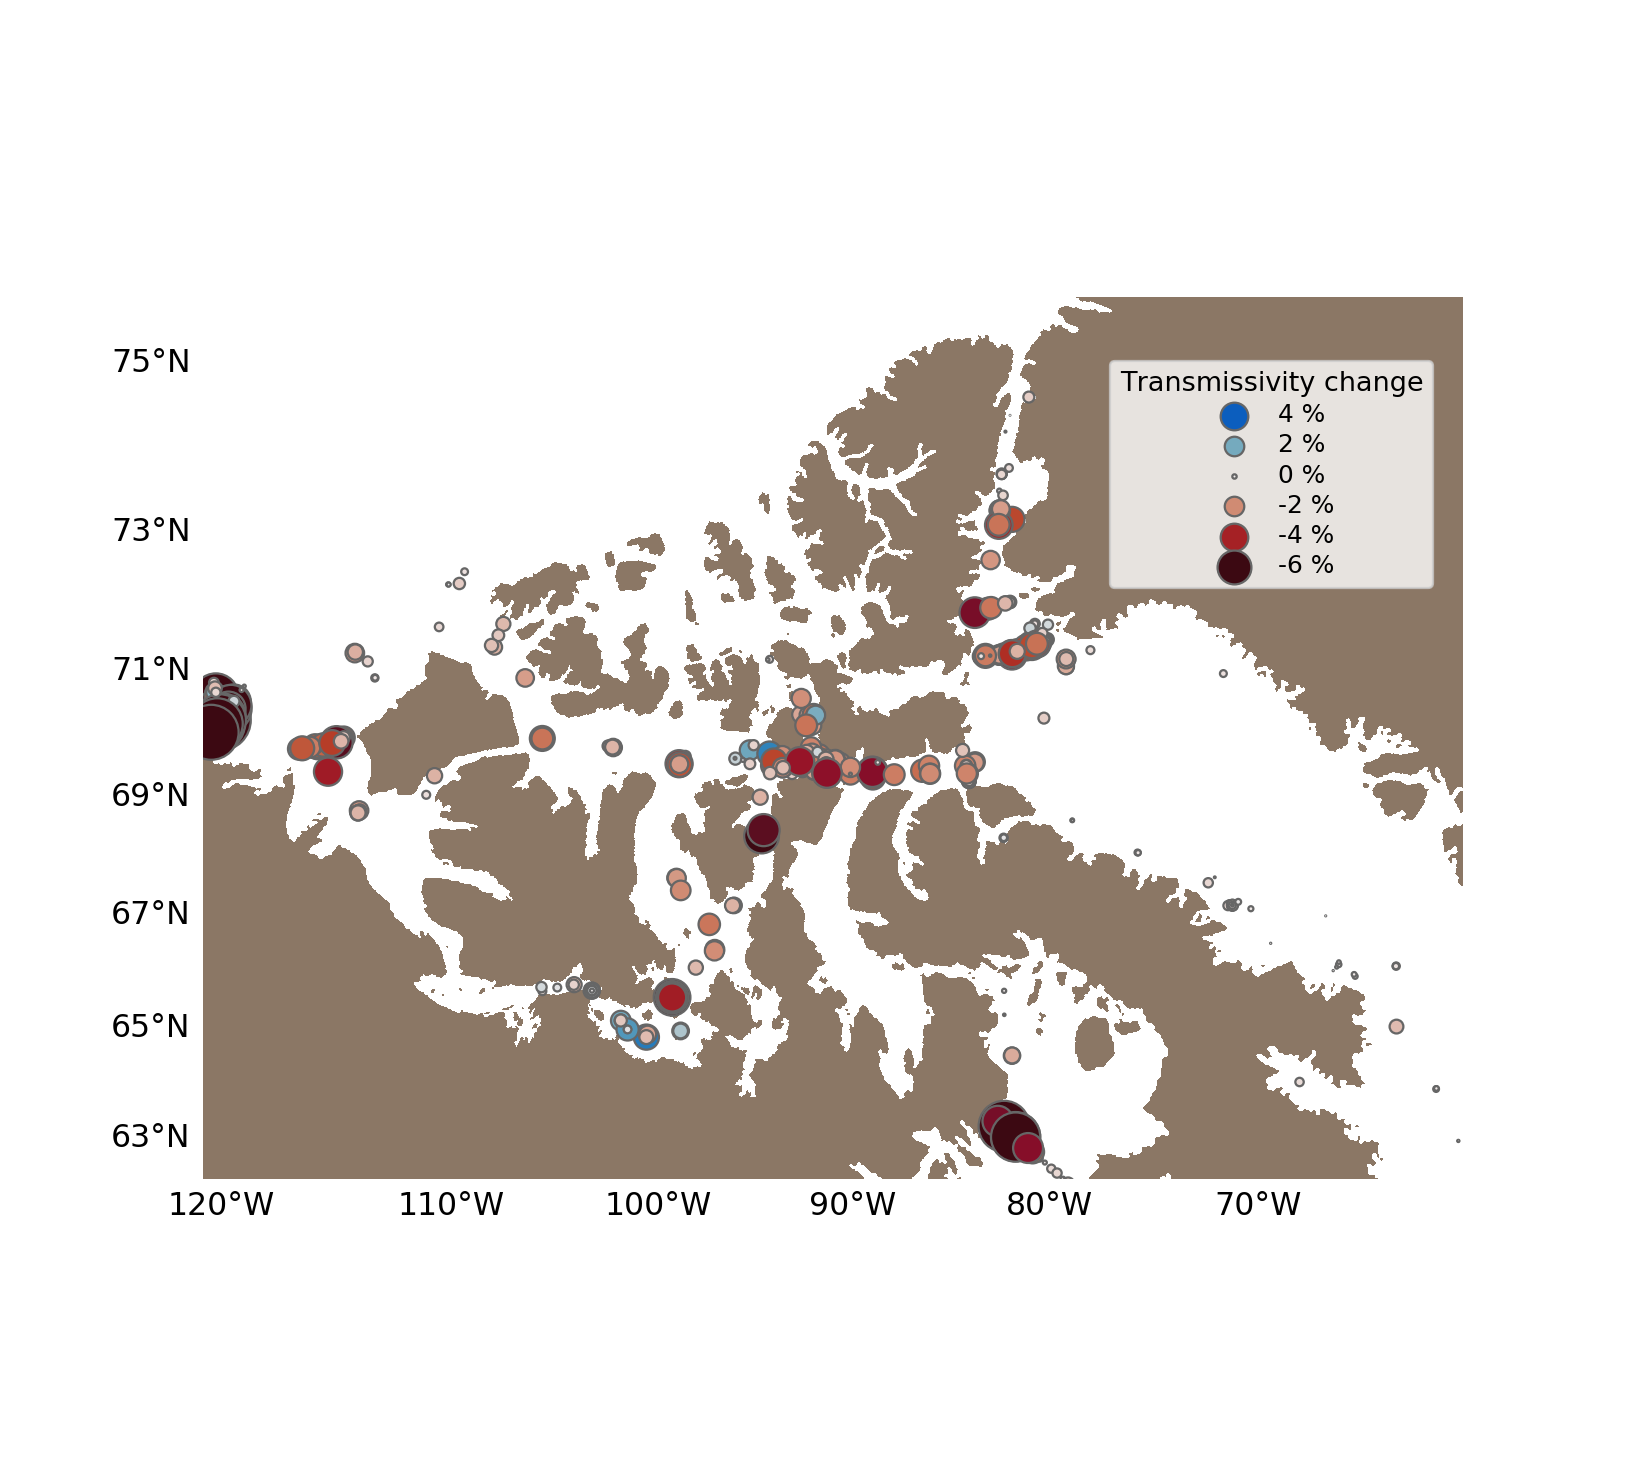

In [216]:
fig, ax1, p1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/caa.pickle','rb'))

x1, y1   = p1(stn_lons1[depth_diff1 < 30], stn_lats1[depth_diff1 < 30])
x2, y2   = p1(stn_lons2[depth_diff2 < 30], stn_lats2[depth_diff2 < 30])
x3, y3   = p1(stn_lons3[depth_diff3 < 30], stn_lats3[depth_diff3 < 30])
x4, y4   = p1(stn_lons4[depth_diff4 < 30], stn_lats4[depth_diff4 < 30])
x5, y5   = p1(stn_lons5[depth_diff5 < 30], stn_lats5[depth_diff5 < 30])
x6, y6   = p1(stn_lons6[depth_diff6 < 30], stn_lats6[depth_diff6 < 30])
x7, y7   = p1(stn_lons7[depth_diff7 < 30], stn_lats7[depth_diff7 < 30])
x8, y8   = p1(stn_lons8[depth_diff8 < 30], stn_lats8[depth_diff8 < 30])
x9, y9   = p1(stn_lons9[depth_diff9 < 30], stn_lats9[depth_diff9 < 30])
x10, y10 = p1(stn_lons10[depth_diff10 < 30], stn_lats10[depth_diff10 < 30])
x11, y11 = p1(stn_lons11[depth_diff11 < 30], stn_lats11[depth_diff11 < 30])
x12, y12 = p1(stn_lons12[depth_diff12 < 30], stn_lats12[depth_diff12 < 30])
x13, y13 = p1(stn_lons13[depth_diff13 < 30], stn_lats13[depth_diff13 < 30])
x15, y15 = p1(stn_lons15[depth_diff15 < 30], stn_lats15[depth_diff15 < 30])

# Plotting parameters:
vmintm  = -6
vmaxtm  = 6
markersz= 350
cmapm   = cmocean.cm.balance_r

CB = p1.scatter(x1[~np.isnan(trans1)], y1[~np.isnan(trans1)], \
                c=trans1[~np.isnan(trans1)], s=np.abs(trans1[~np.isnan(trans1)])*150, \
                marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')

p1.scatter(x2[~np.isnan(trans2)], y2[~np.isnan(trans2)], \
           c=trans2[~np.isnan(trans2)], s=np.abs(trans2[~np.isnan(trans2)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x3[~np.isnan(trans3)], y3[~np.isnan(trans3)], \
           c=trans3[~np.isnan(trans3)], s=np.abs(trans3[~np.isnan(trans3)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x4[~np.isnan(trans4)], y4[~np.isnan(trans4)], \
           c=trans4[~np.isnan(trans4)], s=np.abs(trans4[~np.isnan(trans4)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x5[~np.isnan(trans5)], y5[~np.isnan(trans5)], \
           c=trans5[~np.isnan(trans5)], s=np.abs(trans5[~np.isnan(trans5)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x6[~np.isnan(trans6)], y6[~np.isnan(trans6)], \
           c=trans6[~np.isnan(trans6)], s=np.abs(trans6[~np.isnan(trans6)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x7[~np.isnan(trans7)], y7[~np.isnan(trans7)], \
           c=trans7[~np.isnan(trans7)], s=np.abs(trans7[~np.isnan(trans7)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x8[~np.isnan(trans8)], y8[~np.isnan(trans8)], \
           c=trans8[~np.isnan(trans8)], s=np.abs(trans8[~np.isnan(trans8)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x9[~np.isnan(trans9)], y9[~np.isnan(trans9)], \
           c=trans9[~np.isnan(trans9)], s=np.abs(trans9[~np.isnan(trans9)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x10[~np.isnan(trans10)], y10[~np.isnan(trans10)], \
           c=trans10[~np.isnan(trans10)], s=np.abs(trans10[~np.isnan(trans10)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x11[~np.isnan(trans11)], y11[~np.isnan(trans11)], \
           c=trans11[~np.isnan(trans11)], s=np.abs(trans11[~np.isnan(trans11)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x12[~np.isnan(trans12)], y12[~np.isnan(trans12)], \
           c=trans12[~np.isnan(trans12)], s=np.abs(trans12[~np.isnan(trans12)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x13[~np.isnan(trans13)], y13[~np.isnan(trans13)], \
           c=trans13[~np.isnan(trans13)], s=np.abs(trans13[~np.isnan(trans13)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x15[~np.isnan(trans15)], y15[~np.isnan(trans15)], \
           c=trans15[~np.isnan(trans15)], s=np.abs(trans15[~np.isnan(trans15)])*150, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')

# cbaxes1 = fig.add_axes([0.8, 0.55, 0.04, 0.24])
# CBar = plt.colorbar(CB, cax=cbaxes1, label='Transmissivity change [%]')

# Color bar:
cb = [-6.0, -4.0, -2.0, 0, 2.0, 4.0, 6.0]
xb = -1e6*np.ones(len(cb)); yb = -1e6*np.ones(len(cb));
cb0 = -6*np.ones(len(cb));
cb1 = -4*np.ones(len(cb));  cb2 = -2*np.ones(len(cb));
cb3 = 0.1*np.ones(len(cb)); cb4 = 2*np.ones(len(cb));
cb5 = 4*np.ones(len(cb));   cb6 = 6*np.ones(len(cb));

# p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(0.99)), s=np.abs(cb6)*150, \
#            marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='6 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(5/6)), s=np.abs(cb5)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='4 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(4/6)), s=np.abs(cb4)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='2 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(3/6)), s=np.abs(cb3)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='0 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(2/6)), s=np.abs(cb2)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='-2 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(1/6)), s=np.abs(cb1)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='-4 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(0)), s=np.abs(cb0)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='-6 %')

ax1.legend(scatterpoints=1, frameon=True, labelspacing=0.25, fontsize=11, loc=(0.72,0.67), \
           title='Transmissivity change', title_fontsize=12)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---CAA-bottom-column.png', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


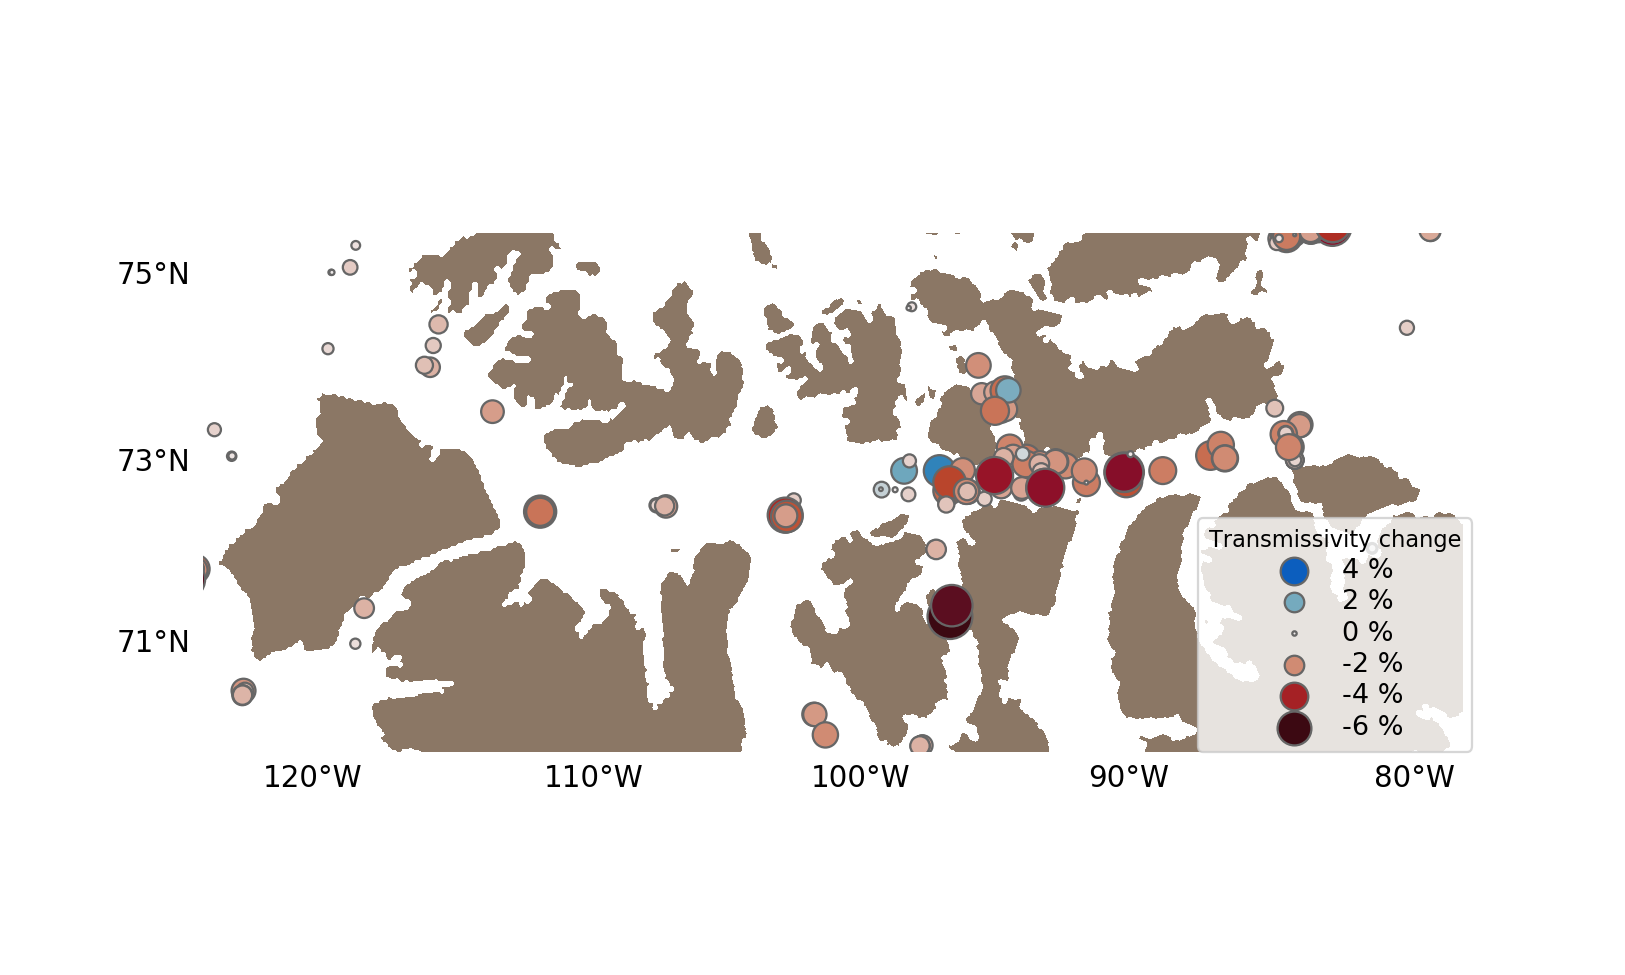

In [215]:
fig, ax1, p1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/parry-channel.pickle','rb'))

x1, y1   = p1(stn_lons1[depth_diff1 < 30], stn_lats1[depth_diff1 < 30])
x2, y2   = p1(stn_lons2[depth_diff2 < 30], stn_lats2[depth_diff2 < 30])
x3, y3   = p1(stn_lons3[depth_diff3 < 30], stn_lats3[depth_diff3 < 30])
x4, y4   = p1(stn_lons4[depth_diff4 < 30], stn_lats4[depth_diff4 < 30])
x5, y5   = p1(stn_lons5[depth_diff5 < 30], stn_lats5[depth_diff5 < 30])
x6, y6   = p1(stn_lons6[depth_diff6 < 30], stn_lats6[depth_diff6 < 30])
x7, y7   = p1(stn_lons7[depth_diff7 < 30], stn_lats7[depth_diff7 < 30])
x8, y8   = p1(stn_lons8[depth_diff8 < 30], stn_lats8[depth_diff8 < 30])
x9, y9   = p1(stn_lons9[depth_diff9 < 30], stn_lats9[depth_diff9 < 30])
x10, y10 = p1(stn_lons10[depth_diff10 < 30], stn_lats10[depth_diff10 < 30])
x11, y11 = p1(stn_lons11[depth_diff11 < 30], stn_lats11[depth_diff11 < 30])
x12, y12 = p1(stn_lons12[depth_diff12 < 30], stn_lats12[depth_diff12 < 30])
x13, y13 = p1(stn_lons13[depth_diff13 < 30], stn_lats13[depth_diff13 < 30])
x15, y15 = p1(stn_lons15[depth_diff15 < 30], stn_lats15[depth_diff15 < 30])

# Plotting parameters:
vmintm  = -6
vmaxtm  = 6
markersz= 350
cmapm   = cmocean.cm.balance_r

CB = p1.scatter(x1[~np.isnan(trans1)], y1[~np.isnan(trans1)], \
                c=trans1[~np.isnan(trans1)], s=np.abs(trans1[~np.isnan(trans1)])*250, \
                marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')

p1.scatter(x2[~np.isnan(trans2)], y2[~np.isnan(trans2)], \
           c=trans2[~np.isnan(trans2)], s=np.abs(trans2[~np.isnan(trans2)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x3[~np.isnan(trans3)], y3[~np.isnan(trans3)], \
           c=trans3[~np.isnan(trans3)], s=np.abs(trans3[~np.isnan(trans3)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x4[~np.isnan(trans4)], y4[~np.isnan(trans4)], \
           c=trans4[~np.isnan(trans4)], s=np.abs(trans4[~np.isnan(trans4)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x5[~np.isnan(trans5)], y5[~np.isnan(trans5)], \
           c=trans5[~np.isnan(trans5)], s=np.abs(trans5[~np.isnan(trans5)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x6[~np.isnan(trans6)], y6[~np.isnan(trans6)], \
           c=trans6[~np.isnan(trans6)], s=np.abs(trans6[~np.isnan(trans6)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x7[~np.isnan(trans7)], y7[~np.isnan(trans7)], \
           c=trans7[~np.isnan(trans7)], s=np.abs(trans7[~np.isnan(trans7)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x8[~np.isnan(trans8)], y8[~np.isnan(trans8)], \
           c=trans8[~np.isnan(trans8)], s=np.abs(trans8[~np.isnan(trans8)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x9[~np.isnan(trans9)], y9[~np.isnan(trans9)], \
           c=trans9[~np.isnan(trans9)], s=np.abs(trans9[~np.isnan(trans9)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x10[~np.isnan(trans10)], y10[~np.isnan(trans10)], \
           c=trans10[~np.isnan(trans10)], s=np.abs(trans10[~np.isnan(trans10)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x11[~np.isnan(trans11)], y11[~np.isnan(trans11)], \
           c=trans11[~np.isnan(trans11)], s=np.abs(trans11[~np.isnan(trans11)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x12[~np.isnan(trans12)], y12[~np.isnan(trans12)], \
           c=trans12[~np.isnan(trans12)], s=np.abs(trans12[~np.isnan(trans12)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x13[~np.isnan(trans13)], y13[~np.isnan(trans13)], \
           c=trans13[~np.isnan(trans13)], s=np.abs(trans13[~np.isnan(trans13)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')
p1.scatter(x15[~np.isnan(trans15)], y15[~np.isnan(trans15)], \
           c=trans15[~np.isnan(trans15)], s=np.abs(trans15[~np.isnan(trans15)])*250, \
           marker='.', zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=1.0, edgecolor='#666666')

# cbaxes1 = fig.add_axes([0.85, 0.27, 0.04, 0.24])
# CBar = plt.colorbar(CB, cax=cbaxes1, label='Transmissivity change [%]')

# Color bar:
cb = [-6.0, -4.0, -2.0, 0, 2.0, 4.0]
xb = -1e6*np.ones(len(cb)); yb = -1e6*np.ones(len(cb));
cb0 = -6*np.ones(len(cb));
cb1 = -4*np.ones(len(cb));  cb2 = -2*np.ones(len(cb));
cb3 = 0.1*np.ones(len(cb)); cb4 = 2*np.ones(len(cb));
cb5 = 4*np.ones(len(cb));   

p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(5/6)), s=np.abs(cb5)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='4 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(4/6)), s=np.abs(cb4)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='2 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(3/6)), s=np.abs(cb3)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='0 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(2/6)), s=np.abs(cb2)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='-2 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(1/6)), s=np.abs(cb1)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='-4 %')
p1.scatter(xb, yb, c=matplotlib.colors.to_hex(cmapm(0)), s=np.abs(cb0)*150, \
           marker='.', zorder=3, alpha=1.0, edgecolor='#666666', label='-6 %')

ax1.legend(scatterpoints=1, frameon=True, labelspacing=0.2, fontsize=12, loc=(0.79, 0), title='Transmissivity change')

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---parry-channel-bottom-column.png', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


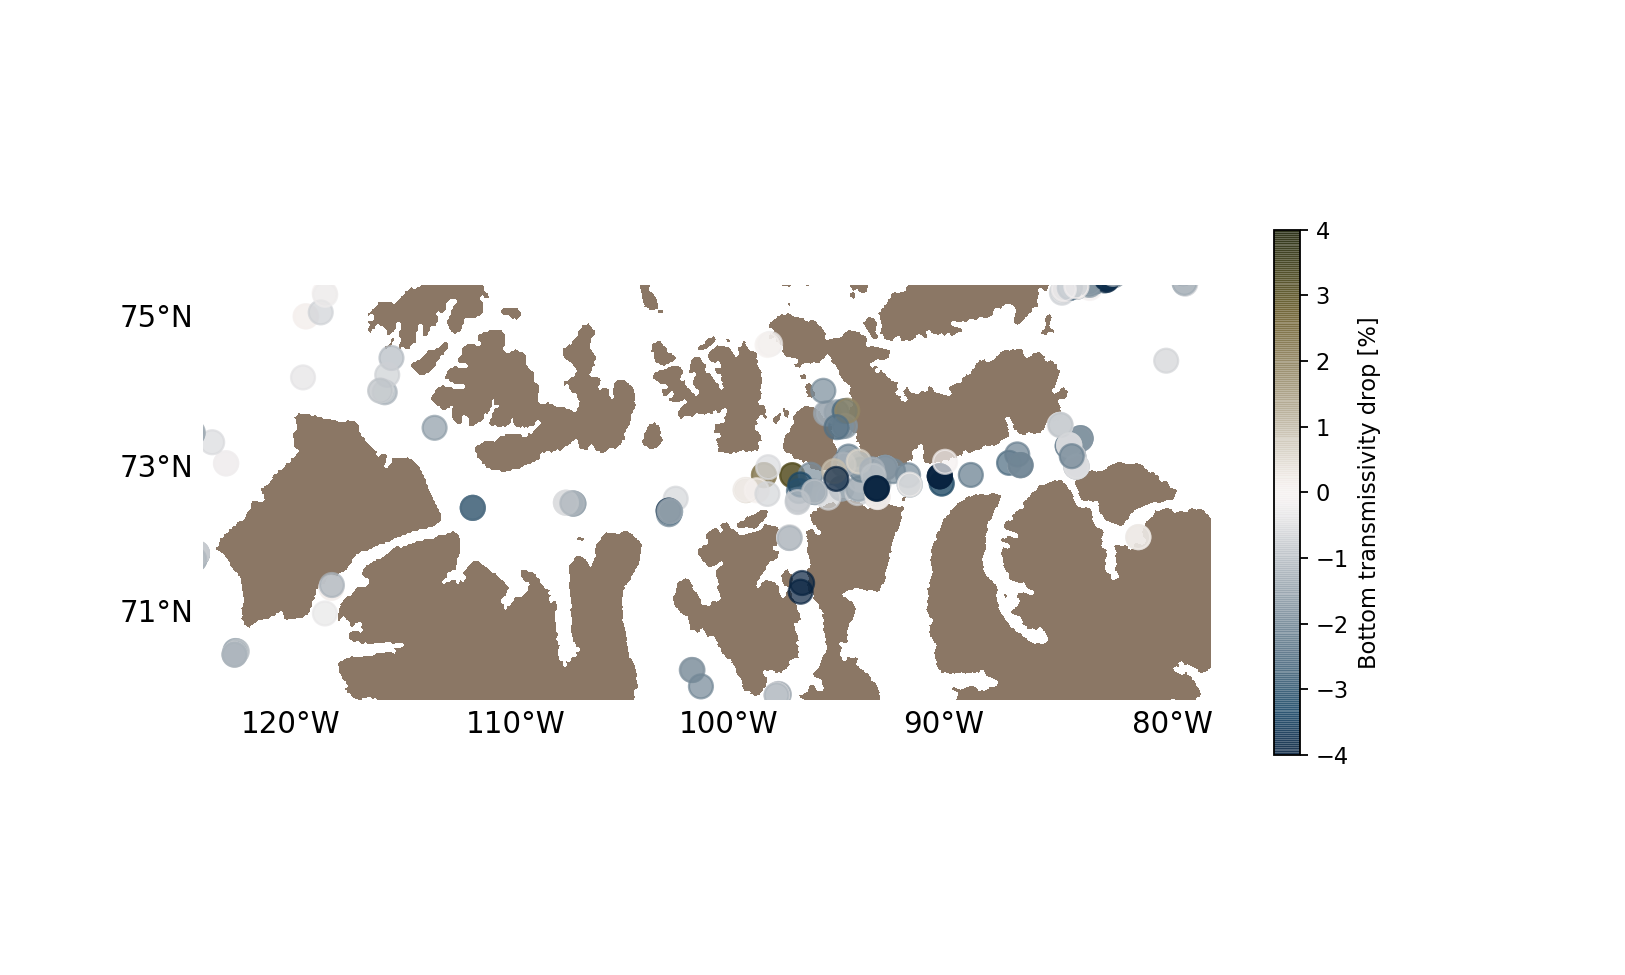

In [73]:
fig, ax1, p1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/parry-channel.pickle','rb'))

x1, y1   = p1(stn_lons1[depth_diff1 < 30], stn_lats1[depth_diff1 < 30])
x2, y2   = p1(stn_lons2[depth_diff2 < 30], stn_lats2[depth_diff2 < 30])
x3, y3   = p1(stn_lons3[depth_diff3 < 30], stn_lats3[depth_diff3 < 30])
x4, y4   = p1(stn_lons4[depth_diff4 < 30], stn_lats4[depth_diff4 < 30])
x5, y5   = p1(stn_lons5[depth_diff5 < 30], stn_lats5[depth_diff5 < 30])
x6, y6   = p1(stn_lons6[depth_diff6 < 30], stn_lats6[depth_diff6 < 30])
x7, y7   = p1(stn_lons7[depth_diff7 < 30], stn_lats7[depth_diff7 < 30])
x8, y8   = p1(stn_lons8[depth_diff8 < 30], stn_lats8[depth_diff8 < 30])
x9, y9   = p1(stn_lons9[depth_diff9 < 30], stn_lats9[depth_diff9 < 30])
x10, y10 = p1(stn_lons10[depth_diff10 < 30], stn_lats10[depth_diff10 < 30])
x11, y11 = p1(stn_lons11[depth_diff11 < 30], stn_lats11[depth_diff11 < 30])
x12, y12 = p1(stn_lons12[depth_diff12 < 30], stn_lats12[depth_diff12 < 30])
x13, y13 = p1(stn_lons13[depth_diff13 < 30], stn_lats13[depth_diff13 < 30])
x15, y15 = p1(stn_lons15[depth_diff15 < 30], stn_lats15[depth_diff15 < 30])

vmintm   = -4
vmaxtm   = 4
markersz = 450
cmapm    = cmocean.cm.diff

CB = p1.scatter(x1[~np.isnan(trans1)], y1[~np.isnan(trans1)], c=trans1[~np.isnan(trans1)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x1[~np.isnan(trans1)], y1[~np.isnan(trans1)], c=trans1[~np.isnan(trans1)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x2[~np.isnan(trans2)], y2[~np.isnan(trans2)], c=trans2[~np.isnan(trans2)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x3[~np.isnan(trans3)], y3[~np.isnan(trans3)], c=trans3[~np.isnan(trans3)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x4[~np.isnan(trans4)], y4[~np.isnan(trans4)], c=trans4[~np.isnan(trans4)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x5[~np.isnan(trans5)], y5[~np.isnan(trans5)], c=trans5[~np.isnan(trans5)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x6[~np.isnan(trans6)], y6[~np.isnan(trans6)], c=trans6[~np.isnan(trans6)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x7[~np.isnan(trans7)], y7[~np.isnan(trans7)], c=trans7[~np.isnan(trans7)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x8[~np.isnan(trans8)], y8[~np.isnan(trans8)], c=trans8[~np.isnan(trans8)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x9[~np.isnan(trans9)], y9[~np.isnan(trans9)], c=trans9[~np.isnan(trans9)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x10[~np.isnan(trans10)], y10[~np.isnan(trans10)], c=trans10[~np.isnan(trans10)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x11[~np.isnan(trans11)], y11[~np.isnan(trans11)], c=trans11[~np.isnan(trans11)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x12[~np.isnan(trans12)], y12[~np.isnan(trans12)], c=trans12[~np.isnan(trans12)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x13[~np.isnan(trans13)], y13[~np.isnan(trans13)], c=trans13[~np.isnan(trans13)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)
p1.scatter(x15[~np.isnan(trans15)], y15[~np.isnan(trans15)], c=trans15[~np.isnan(trans15)], \
           marker='.', s=markersz, zorder=3, cmap=cmapm, vmin=vmintm, vmax=vmaxtm, alpha=0.7)

# caxes= plt.add_axes()
CBar = plt.colorbar(CB, shrink=0.7, drawedges=False, label='Bottom transmissivity drop [%]')

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---parry-channel-full-column.png', bbox_inches='tight', dpi=300)

### Add tidal speed/erosion rate to the background:

In [212]:
mat         = scipy.io.loadmat('/ocean/brogalla/GEOTRACES/data/mean_tide_speed.mat')
tidal_speed = mat['mean_speed']

ts_mesh     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/hsquare.nc')
ts_lons     = np.array(ts_mesh.variables['nav_lon'])
ts_lats     = np.array(ts_mesh.variables['nav_lat'])

In [256]:
erosion_rate = 0.3e-6*tidal_speed**2
# erosion_rate[tidal_speed < 0.08] = np.nan
log_erosion_rate = np.log10(erosion_rate)

<IPython.core.display.Javascript object>


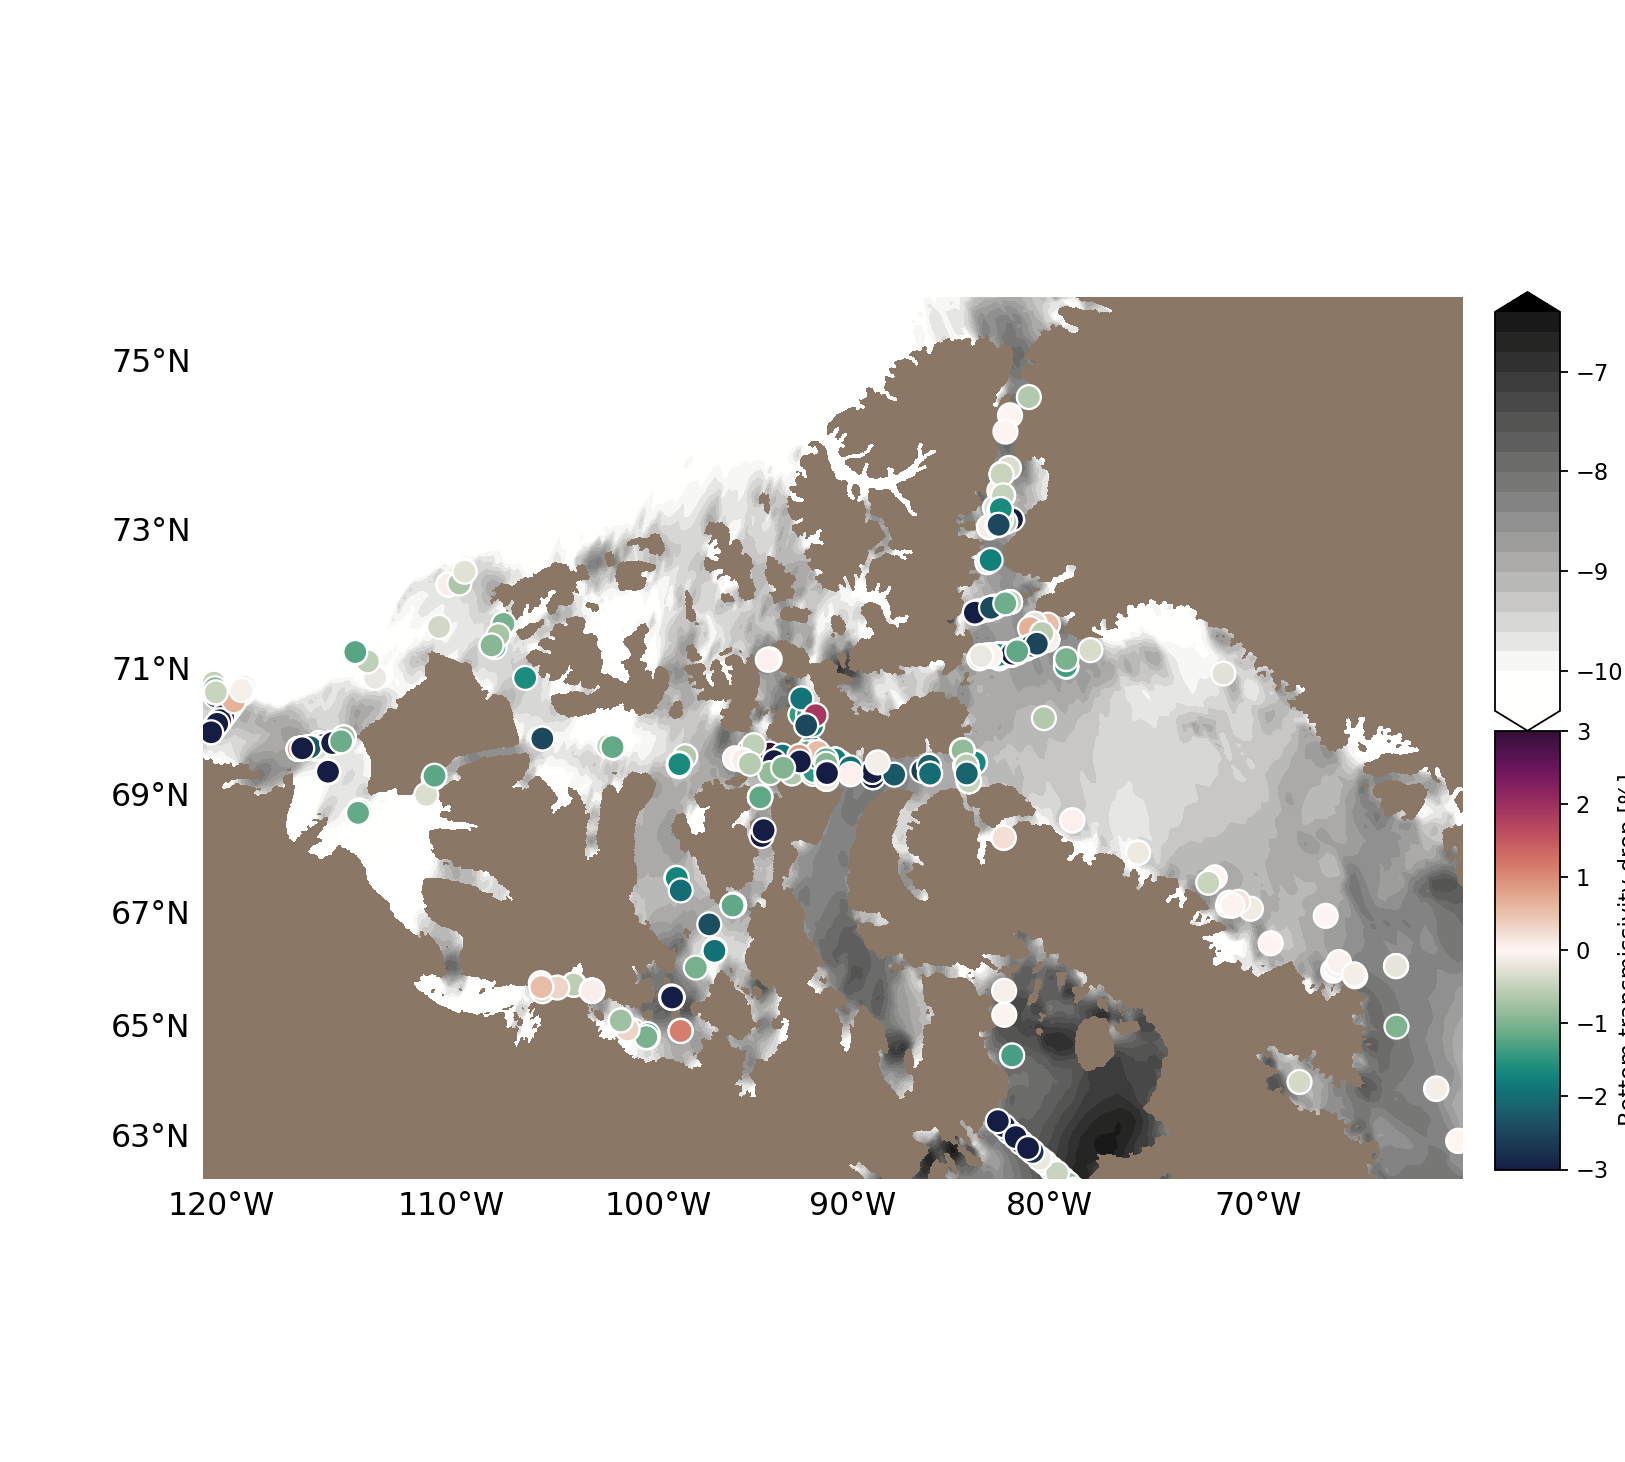

In [285]:
fig, ax1, p1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/caa.pickle','rb'))

x_JL, y_JL  = p1(ts_lons, ts_lats) 

log_ER   = np.ma.masked_where((log_erosion_rate < -10.5), log_erosion_rate)
ER       = p1.contourf(x_JL, y_JL, log_ER, 20, vmin=-10, vmax=-6, cmap=cmocean.cm.gray_r, extend='both')

x1, y1   = p1(stn_lons1[depth_diff1 < 30], stn_lats1[depth_diff1 < 30])
x2, y2   = p1(stn_lons2[depth_diff2 < 30], stn_lats2[depth_diff2 < 30])
x3, y3   = p1(stn_lons3[depth_diff3 < 30], stn_lats3[depth_diff3 < 30])
x4, y4   = p1(stn_lons4[depth_diff4 < 30], stn_lats4[depth_diff4 < 30])
x5, y5   = p1(stn_lons5[depth_diff5 < 30], stn_lats5[depth_diff5 < 30])
x6, y6   = p1(stn_lons6[depth_diff6 < 30], stn_lats6[depth_diff6 < 30])
x7, y7   = p1(stn_lons7[depth_diff7 < 30], stn_lats7[depth_diff7 < 30])
x8, y8   = p1(stn_lons8[depth_diff8 < 30], stn_lats8[depth_diff8 < 30])
x9, y9   = p1(stn_lons9[depth_diff9 < 30], stn_lats9[depth_diff9 < 30])
x10, y10 = p1(stn_lons10[depth_diff10 < 30], stn_lats10[depth_diff10 < 30])
x11, y11 = p1(stn_lons11[depth_diff11 < 30], stn_lats11[depth_diff11 < 30])
x12, y12 = p1(stn_lons12[depth_diff12 < 30], stn_lats12[depth_diff12 < 30])
x13, y13 = p1(stn_lons13[depth_diff13 < 30], stn_lats13[depth_diff13 < 30])
x15, y15 = p1(stn_lons15[depth_diff15 < 30], stn_lats15[depth_diff15 < 30])

alphaval=1.0
markersz=450
vmintm  = -3
vmaxtm  = 3

CB = p1.scatter(x1[~np.isnan(trans1)], y1[~np.isnan(trans1)], c=trans1[~np.isnan(trans1)], \
                   marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, \
                   alpha=alphaval, edgecolor='w')
p1.scatter(x1[~np.isnan(trans1)], y1[~np.isnan(trans1)], c=trans1[~np.isnan(trans1)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x2[~np.isnan(trans2)], y2[~np.isnan(trans2)], c=trans2[~np.isnan(trans2)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x3[~np.isnan(trans3)], y3[~np.isnan(trans3)], c=trans3[~np.isnan(trans3)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x4[~np.isnan(trans4)], y4[~np.isnan(trans4)], c=trans4[~np.isnan(trans4)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x5[~np.isnan(trans5)], y5[~np.isnan(trans5)], c=trans5[~np.isnan(trans5)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x6[~np.isnan(trans6)], y6[~np.isnan(trans6)], c=trans6[~np.isnan(trans6)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x7[~np.isnan(trans7)], y7[~np.isnan(trans7)], c=trans7[~np.isnan(trans7)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x8[~np.isnan(trans8)], y8[~np.isnan(trans8)], c=trans8[~np.isnan(trans8)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x9[~np.isnan(trans9)], y9[~np.isnan(trans9)], c=trans9[~np.isnan(trans9)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x10[~np.isnan(trans10)], y10[~np.isnan(trans10)], c=trans10[~np.isnan(trans10)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x11[~np.isnan(trans11)], y11[~np.isnan(trans11)], c=trans11[~np.isnan(trans11)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x12[~np.isnan(trans12)], y12[~np.isnan(trans12)], c=trans12[~np.isnan(trans12)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x13[~np.isnan(trans13)], y13[~np.isnan(trans13)], c=trans13[~np.isnan(trans13)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')
p1.scatter(x15[~np.isnan(trans15)], y15[~np.isnan(trans15)], c=trans15[~np.isnan(trans15)], \
           marker='.', s=markersz, zorder=3, cmap=cmocean.cm.curl, vmin=vmintm, vmax=vmaxtm, alpha=alphaval,\
           edgecolor='w')

cbaxes1 = fig.add_axes([0.92, 0.2, 0.04, 0.3])
cbaxes2 = fig.add_axes([0.92, 0.5, 0.04, 0.3])
CB1 = plt.colorbar(CB, cax=cbaxes1, label='Bottom transmissivity drop [%]')
CB2 = plt.colorbar(ER, cax=cbaxes2, ticks=[-10,-9,-8,-7,-6], label='Log of erosion rate')

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---transmissivity-drop-map.png', bbox_inches='tight', dpi=300)

# Old stuff:

<IPython.core.display.Javascript object>


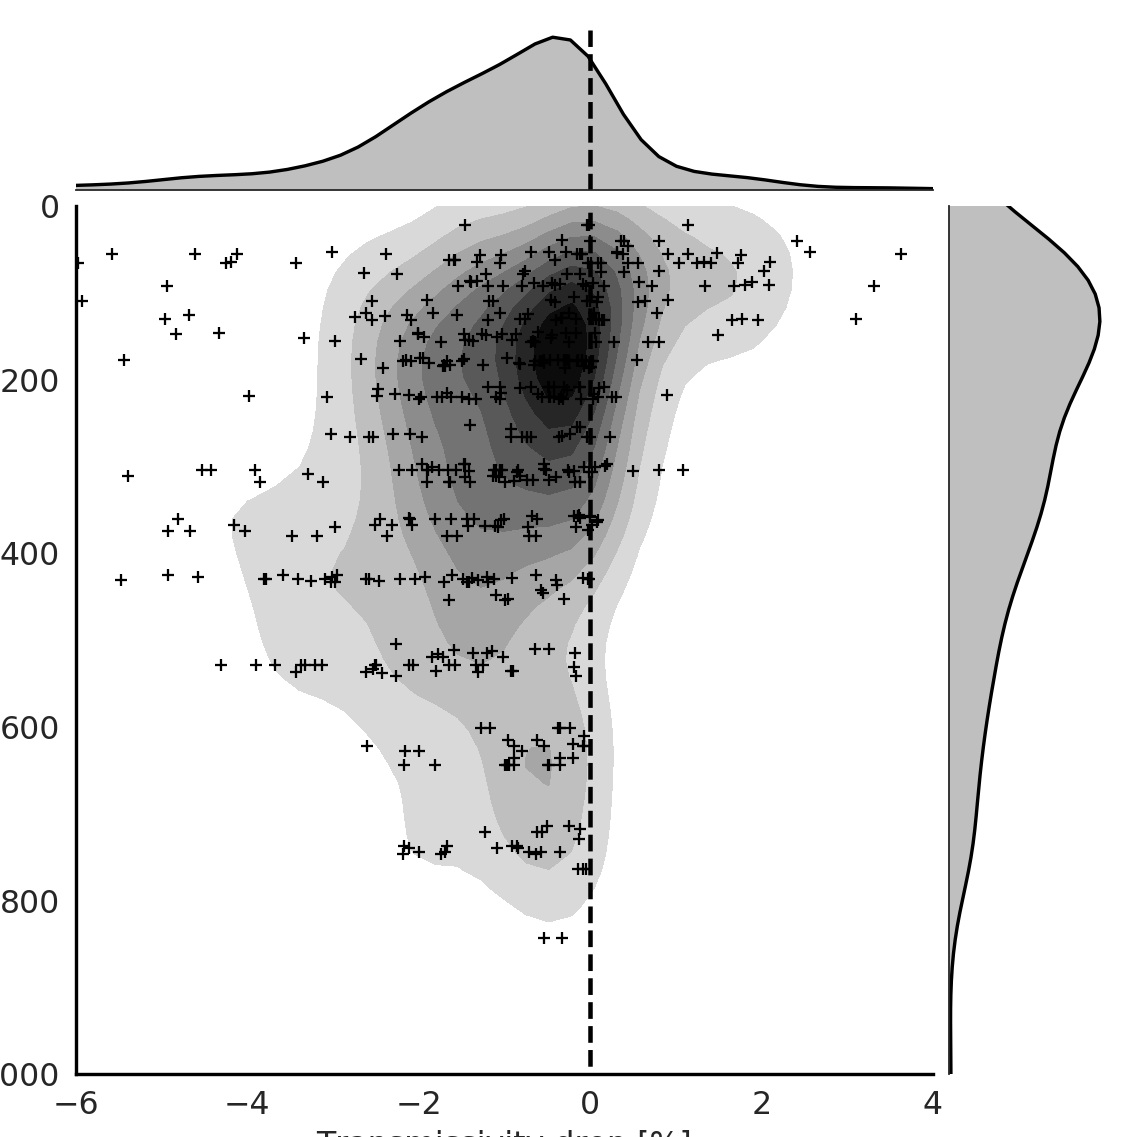

In [279]:
with sns.axes_style("white"):
    jp = sns.jointplot(x=transmissivity, y=bathymetry_depth, height=7, space=0.1, \
                       kind='kde',color="k")
    jp.plot_joint(plt.scatter, c="k", s=25, linewidth=1.0, marker="+")
    jp.ax_joint.collections[0].set_alpha(0)
    jp.ax_joint.set_xlim(-6,4)
    jp.ax_joint.set_ylim(1000,0)
    
    jp.ax_joint.plot([0,0], [1200,0], '--k', linewidth=2)
    jp.ax_marg_x.axvline(x=0, c='k', linestyle='--', linewidth=2)
    
    jp.ax_joint.spines['left'].set_linewidth(1.5);   jp.ax_joint.spines['left'].set_color('black');
    jp.ax_joint.spines['bottom'].set_linewidth(1.5); jp.ax_joint.spines['bottom'].set_color('black');
    jp.ax_joint.spines['right'].set_linewidth(1.5);  jp.ax_joint.spines['right'].set_color('black');
    jp.ax_joint.spines['top'].set_linewidth(1.5);    jp.ax_joint.spines['top'].set_color('black');
    jp.ax_joint.tick_params(axis='both', which='major', labelsize=14)
    
    jp.set_axis_labels("Transmissivity drop [%]", "Bathymetry depth [m]", fontsize=14)